##### Notebook 02: Analysis

# US FOMC Communication Interest Rate Forecaster

### Contents:
- [01: Spell Checker](#01:-Spell-Checker)
- [02: Import Data](#02:-Import-Data)
- [03: Data Modifications](#03:-Data-Modification)
- [04: Target Value Creation](#04:-Target-Value-Creation)
- [05: Modelling](#05:-Modelling)
- [06: Model Reivew](#06:-Model-Reivew)
- [07: Final Model Tuning and Partial Data Testing](#07:-Final-Model-Tuning-and-Partial-Data-Testing)
- [08: Review of Results and Moving Average Addition](#08:-Review-of-Results-and-Moving-Average-Addition)
- [09: Decreasing the Training Sample](#09:-Decreasing-the-Training-Sample)
- [10: Final Model Review and Conclusion](#10:-Final-Model-Review-and-Conclusion)


In [296]:
## Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from symspellpy.symspellpy import SymSpell, Verbosity
from nltk.stem import SnowballStemmer
from xgboost import XGBClassifier, plot_importance
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora, models
import pyLDAvis.gensim
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

pyLDAvis.enable_notebook()
%matplotlib inline

### 01: Spell Checker
Optional spell checker function.  This only needs to be ran on new documents or to improve spelling checking on existing cells.  Errors exist in the files from the PDF text extractor, it works imperfectly.  The sym spell library has several parameters for throttling the accuracy of the spell checking, based on computational resources and time available.  For this project, a light spell check pass was completed only.  Typos and word fragments still remain.  <br>
<br>
This section is optional, and due to the time constraint, should only be run if needed for another spell check pass.  The spell checked text will be saved over the CSV as it progresses.

In [297]:
## Import texts that already have a partial spell check completed
## Useful if processing spell checking one part a time

df_texts = pd.read_csv('./data/df_texts_spellchecked.csv')
df_texts.drop('Unnamed: 0', inplace=True, axis=1)
df_texts['date'] = pd.to_datetime(df_texts['date'])
df_texts.head()

## Text rows completed so far: 592

,date,text
0,2018-01-17,The Beige Book Summary of Commentary on Curren...
1,2018-03-07,The Beige Book Summary of Commentary on Curren...
2,2018-04-18,The Beige Book Summary of Commentary on Curren...
3,2018-05-30,The Beige BookSummary of Commentary on Current...
4,2018-06-13,Minutes of the Federal Open Market Committ...


In [298]:
df_texts.shape

(644, 2)

In [ ]:
## Spell check function
## Use the counter to mark which row was last completed, useful if running the spell check in partial chunks

counter = 593
# Dictionary path - Change to filepath of project location
dictionary_path = 'C:/sdm/GIT/DSI/Capstone/frequency_dictionary_en_82_765.txt'

initial_capacity = 83000 # increase to improve accuracy at cost of speed
max_edit_distance_dictionary = 1 # increase to improve accuracy at cost of speed
prefix_length = 7 # increase to improve accuracy at cost of speed
term_index = 0  # column of the term in the dictionary text file
count_index = 1  # column of the term frequency in the dictionary text file

for x in range(593,644):
    sym_spell = SymSpell(initial_capacity, max_edit_distance_dictionary,
                         prefix_length)
    sym_spell.load_dictionary(dictionary_path, 0, 1)
    if not sym_spell.load_dictionary(dictionary_path, term_index, count_index):
        print("Dictionary file not found")
    
    string_variable = sym_spell.word_segmentation(df_texts.iloc[x][1])
    
    df_texts.iloc[x][1] = string_variable.corrected_string
    print(counter)
    counter += 1
    df_texts.to_csv('./data/df_texts_spellchecked.csv', sep=',')

### 02: Import Data
Interest rate and FOMC communications.

In [299]:
## Interest Rates

df_int= pd.read_csv('./data/data.csv')
df_int.rename(index=str, columns={'Unnamed: 0': 'date'}, inplace=True)
df_int['date'] = pd.to_datetime(df_int['date'])

In [300]:
## FOMC Communications

df_texts = pd.read_csv('./data/df_texts_spellchecked.csv')
df_texts.drop('Unnamed: 0', inplace=True, axis=1)
df_texts['date'] = pd.to_datetime(df_texts['date'])
df_texts.head()

,date,text
0,2018-01-17,The Beige Book Summary of Commentary on Curren...
1,2018-03-07,The Beige Book Summary of Commentary on Curren...
2,2018-04-18,The Beige Book Summary of Commentary on Curren...
3,2018-05-30,The Beige BookSummary of Commentary on Current...
4,2018-06-13,Minutes of the Federal Open Market Committ...


### 03: Data Modification
Interest rates are provided for daily rates, this needs to be converted to monthly rates to match FOMC communication dates.  The mean monthly interest rate will be used.  After, the six month following rate change will be calculated.
1. Mean interest rate conversion, both dataframes combined
2. Six month difference calculated

In [301]:
## Convert to monthly data, combine to single dataframe

df_int.set_index(['date'], inplace=True)
df_int = df_int.resample("M").mean()
df_texts.set_index(['date'], inplace=True)
df_texts.sort_index(inplace=True)
df_texts.index = df_texts.index + pd.offsets.MonthBegin(1)
df_int.index = df_int.index + pd.offsets.MonthBegin(1)
df_complete = df_texts.join(df_int)
df_complete.head(5)

,text,rate
date,,
1960-02-01,A meeting of the Federal Open Market Committee...,3.991935
1960-03-01,A meeting of the Federal Open Market Committee...,3.965517
1960-04-01,A meeting of the Federal Open Market Committee...,3.838710
1960-05-01,A meeting of the Federal Open Market Committee...,3.916667
1960-06-01,A meeting of the Federal Open Market Committee...,3.846774


In [302]:
## Calculate 6 month change

df_temp = df_complete.copy()
df_temp['change_6'] = df_complete['rate'].diff(6)
df_temp.head(10)

,text,rate,change_6
date,,,
1960-02-01,A meeting of the Federal Open Market Committee...,3.991935,NaN
1960-03-01,A meeting of the Federal Open Market Committee...,3.965517,NaN
1960-04-01,A meeting of the Federal Open Market Committee...,3.838710,NaN
1960-05-01,A meeting of the Federal Open Market Committee...,3.916667,NaN
1960-06-01,A meeting of the Federal Open Market Committee...,3.846774,NaN
1960-07-01,A meeting of the Federal Open Market Committee...,3.316667,NaN
1960-08-01,A meeting of the Federal Open Market Committee...,3.225806,-0.766129
1960-09-01,A meeting of the Federal Open Market Committee...,2.975806,-0.989711
1960-10-01,A meeting of the Federal Open Market Committee...,2.600000,-1.238710


In [303]:
## Shift the interest rate change records up
df_temp['change_6'] = df_temp['change_6'].shift(-6)

### 04: Target Value Creation
Target value will not be the exact interest rate, it will be the following 6 month sentiment (hawkish, dovish, neutral).  Since the actual interest rate varies day to day by slight amounts, a threshold will be set that the 6 month change must exceed for it to be considered a change.  

In [304]:
y = df_temp[['change_6']]

# Drop the NAN columns
text = df_temp[:-6]
y = y[:-6]

y_threshold = 0.25

# Create y-target, with threshold for minimum change
y.mask(y > y_threshold, 1, inplace=True)
y.mask(y < -y_threshold, -1, inplace=True)
y.mask((y > -y_threshold) & (y < 0.25), 0, inplace=True)
y.head()

,change_6
date,
1960-02-01,-1.0
1960-03-01,-1.0
1960-04-01,-1.0
1960-05-01,-1.0
1960-06-01,-1.0


In [305]:
text.shape

(638, 3)

In [306]:
y.shape

(638, 1)

In [307]:
## Check for class balance

y['change_6'].value_counts()

 1.0    243
-1.0    204
 0.0    191
Name: change_6, dtype: int64

### 05: Modelling
This will include preprocessing, model fitting, model accuracy testing.
1. Lower case
2. Stemming
3. TFIDF vectorizer
4. Modelling

In [308]:
## Lower case

text['text'] = [i.lower() for i in text['text']]

In [309]:
## Stemming

snow = SnowballStemmer('english',)
text['text'] = [snow.stem(i) for i in text['text']]

In [204]:
## Save stemmed tech to CSV, or load stemmed text from CSV
## Shortcut for model evaluation and TFIDF parameter changes

# Save stemmed documents to CSV
# text.to_csv('./data/text_stemmed.csv', sep=',')

# Load texts from CSV
text = pd.read_csv('./data/text_stemmed.csv')

In [310]:
## Instantiate a TFIDF vectorizer

vect = TfidfVectorizer(stop_words='english', 
                       max_features = 6000, 
                       ngram_range=(2,5),
                       token_pattern='[a-zA-Z]+')
X_text = vect.fit_transform(text['text'])

# Create a DataFrame to examine
text = pd.DataFrame(X_text.toarray(), columns=vect.get_feature_names())
text_tfidf = text.copy() # create backup of TFIDF text for later use
text.head()

,abroad foreign,acceptances period,accordance following,according moody,according moody s,according moody s bond,according moody s bond ratings,according preliminary,account accordance,account accordance following,...,yield curve estimated,yield curves,yield spreads,yield year,york authorized,york authorized directed,york bank,york city,york mr,york state
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.038991,0.016550,0.011090,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.018800,0.000000,0.010695,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.007055,0.0,0.046741,0.005669,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.008373,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.011149,0.000000,0.000000,0.0


In [448]:
## XGBoost model fitting and testing

xgb_model = XGBClassifier(objective='multi:softmax',
                          max_depth=3,
                          num_classes=3)

train_scores = []
test_scores = []

for x in range(1,5):
    X_train, X_test, y_train, y_test = train_test_split(text, y)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    test_score = round(xgb_model.score(X_test, y_test),2)
    train_score = round(xgb_model.score(X_train, y_train),2)
    # print(f'{xgb_model.get_params}')
    print(f'Run {x}... train: {train_score}, test: {test_score}')
    train_scores.append(train_score)
    test_scores.append(test_score)

print(f'Train average: {np.mean(train_scores)}')
print(f'Test average: {np.mean(test_scores)}')

Run 1... train: 1.0, test: 0.64
Run 2... train: 0.99, test: 0.67
Run 3... train: 1.0, test: 0.65
Run 4... train: 0.99, test: 0.64
Train average: 0.9950000000000001
Test average: 0.65


### 06: Model Reivew
1. Feature Importance
2. LDA
3. Plotting Results

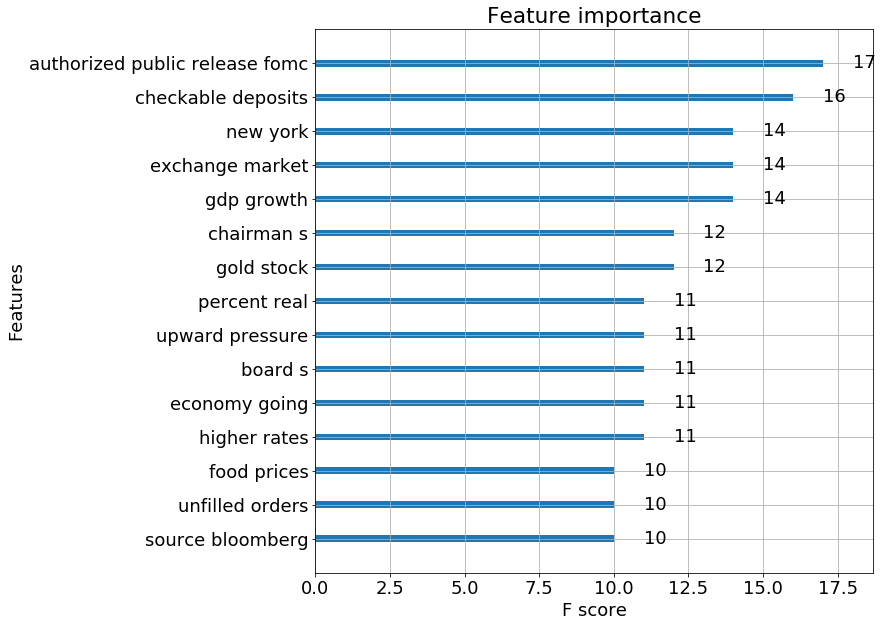

In [450]:
## Feature importance

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 18})
ax.yaxis.label.set_size(18)
plot_importance(xgb_model, max_num_features = 15, ax=ax);

In [208]:
## Re-import the documents for LDA
## Clean dataframe to work with, due to the need for splitting the text into categories

text = pd.read_csv('./data/text_stemmed.csv')
text.head()

,date,text,rate,change_6
0,1960-08-01,a meeting of the federal open market committee...,3.225806,-0.766129
1,1960-09-01,a meeting of the federal open market committee...,2.975806,-0.989711
2,1960-10-01,a meeting of the federal open market committee...,2.600000,-1.238710
3,1960-11-01,a meeting of the federal open market committee...,2.467742,-1.448925
4,1960-12-01,a meeting of the federal open market committee...,2.441667,-1.405108


In [209]:
## Recreate the y-targets
# y_threshold = 0.25
text['y'] = text['change_6']

# Create y-target, with threshold for minimum change
text['y'].mask(text['y'] > y_threshold, 1, inplace=True)
text['y'].mask(text['y'] < -y_threshold, -1, inplace=True)
text['y'].mask((text['y'] > -y_threshold) & (text['y'] < 0.25), 0, inplace=True)
text.head()

,date,text,rate,change_6,y
0,1960-08-01,a meeting of the federal open market committee...,3.225806,-0.766129,-1.0
1,1960-09-01,a meeting of the federal open market committee...,2.975806,-0.989711,-1.0
2,1960-10-01,a meeting of the federal open market committee...,2.600000,-1.238710,-1.0
3,1960-11-01,a meeting of the federal open market committee...,2.467742,-1.448925,-1.0
4,1960-12-01,a meeting of the federal open market committee...,2.441667,-1.405108,-1.0


In [210]:
## Split to 3 dataframes based on y-target actual caregory

df_inc = text[text['y'] == 1]
df_neu = text[text['y'] == 0]
df_dec = text[text['y'] == -1]

In [211]:
## Initiate count vectorizer, or TFIDF vectorizer for the LDA topic evaluation

# cv = CountVectorizer(min_df=0.02, 
#                      stop_words='english', 
#                      token_pattern='[a-zA-Z]+', 
#                      max_features=6000)

cv = TfidfVectorizer(stop_words='english', 
                       max_features = 6000, 
                       ngram_range=(3,5),
                       token_pattern='[a-zA-Z]+')

df_inc_c = cv.fit_transform(df_inc['text'])
df_inc_v = pd.DataFrame(df_inc_c.toarray(), columns=cv.get_feature_names())
df_neu_c = cv.fit_transform(df_neu['text'])
df_neu_v = pd.DataFrame(df_neu_c.toarray(), columns=cv.get_feature_names())
df_dec_c = cv.fit_transform(df_dec['text'])
df_dec_v = pd.DataFrame(df_dec_c.toarray(), columns=cv.get_feature_names())

In [212]:
## LDA analysis for increase event text

lda = LatentDirichletAllocation(2)

lda.fit(df_inc_v)
token_text = [df_inc_v.columns[df_inc_v.loc[index,:].nonzero()] for index in df_inc_v.index]
dictionary = corpora.Dictionary(token_text)
corpus = [dictionary.doc2bow(df_inc_v) for text in token_text]
ldamodel = models.ldamodel.LdaModel(corpus,                     
                                    id2word = dictionary,       # Matches each word to its "number" or "spot" in the dictionary
                                    num_topics = 2,             # Number of topics T to find
                                    passes = 5,                 # Number of passes through corpus; similar to number of epochs
                                    minimum_probability = 0.01) # Only include topics above this probability threshold
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.003321  0.0       1        1  50.656937
0     -0.003321  0.0       2        1  49.343060, topic_info=     Category        Freq                                               Term  \
term                                                                           
3891  Default  243.000000                                 natural gas prices   
3640  Default  242.000000                                 period final month   
3932  Default  243.000000                  private housing activity millions   
3946  Default  242.000000                                  rate monthly rate   
932   Default  243.000000                  savings deposits commercial banks   
3922  Default  243.000000               employment thousands employees based   
3870  Default  242.000000                   short intermediate term business   
4864  Default  243.000000                                    rating new home   
5412  Default  243.000000      department commerce bureaus economic analysis   
5600  Default  243.000000                       averages responses questions   
4833  Default  243.000000                        participation rates percent   
5188  Default  242.000000  economicand financial conditionsrecent develop...   
1696  Default  243.000000                                 growth second half   
5001  Default  243.000000  reserve domestic nonfinancialdevelopments dome...   
5534  Default  242.000000                              q percent change year   
549   Default  243.000000                              foreign central banks   
2062  Default  242.000000                                      july aug sept   
1450  Default  243.000000                written reports mr holmes commented   
4785  Default  243.000000                    imports goods services billions   
5875  Default  243.000000               conditions federal reserve districts   
877   Default  242.000000                                 committee s policy   
2912  Default  242.000000                            industrial production n   
5543  Default  243.000000            quarterly data estimated staff reported   
5708  Default  242.000000                           compared previous survey   
127   Default  242.000000                        meeting federal open market   
3955  Default  243.000000                                        isn t going   
5356  Default  242.000000                    federal funds rate basis points   
5752  Default  243.000000                               service sector firms   
4081  Default  243.000000                                       rice mr rice   
2393  Default  243.000000                           million unit annual rate   
...       ...         ...                                                ...   
3891   Topic2  169.755447                                 natural gas prices   
3932   Topic2  165.508316                  private housing activity millions   
932    Topic2  165.128510                  savings deposits commercial banks   
3922   Topic2  164.609695               employment thousands employees based   
4864   Topic2  164.067307                                    rating new home   
5412   Topic2  163.840744      department commerce bureaus economic analysis   
5600   Topic2  163.124954                       averages responses questions   
4833   Topic2  163.113510                        participation rates percent   
1696   Topic2  162.923660                                 growth second half   
5001   Topic2  162.746216  reserve domestic nonfinancialdevelopments dome...   
549    Topic2  162.124130                              foreign central banks   
1450   Topic2  161.027374                written reports mr holmes commented   
4785   Topic2  161.025360                    imports goods services billions   
5875   Topic2  160.729462               conditions federal reserve districts   
5

In [213]:
## LDA for neutral event text

lda = LatentDirichletAllocation(2)

lda.fit(df_neu_v)
token_text = [df_neu_v.columns[df_neu_v.loc[index,:].nonzero()] for index in df_neu_v.index]
dictionary = corpora.Dictionary(token_text)
corpus = [dictionary.doc2bow(df_neu_v) for text in token_text]
ldamodel = models.ldamodel.LdaModel(corpus,                     
                                    id2word = dictionary,       # Matches each word to its "number" or "spot" in the dictionary
                                    num_topics = 2,             # Number of topics T to find
                                    passes = 5,                 # Number of passes through corpus; similar to number of epochs
                                    minimum_probability = 0.01) # Only include topics above this probability threshold
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.003211  0.0       1        1  50.595898
0     -0.003211  0.0       2        1  49.404102, topic_info=     Category        Freq                                          Term  \
term                                                                      
2940  Default  191.000000                         real gdp rose percent   
4266  Default  190.000000                          jan feb mar real gdp   
5562  Default  191.000000                             factor shock mpol   
3397  Default  191.000000                        previous period saar q   
5171  Default  191.000000                    previous tealbook personal   
3346  Default  190.000000                            n housing starts n   
172   Default  190.000000        research statistics board governors mr   
744   Default  191.000000                      reserve base bank credit   
1434  Default  191.000000                    period seasonally adjusted   
4565  Default  190.000000                                      s p case   
2816  Default  191.000000                         having favorable view   
3589  Default  190.000000                          prices raw materials   
546   Default  191.000000          division international finance board   
4081  Default  191.000000                 prices internationally traded   
11    Default  190.000000                        assistant secretary mr   
2584  Default  190.000000                                 q q q mar apr   
1105  Default  191.000000                          inthe second quarter   
726   Default  191.000000                        committee s objectives   
5521  Default  191.000000        october page authorized public release   
4211  Default  191.000000                 smoothed treasury yield curve   
2500  Default  191.000000        ii federal government outlays receipts   
4293  Default  191.000000          fomc secretariat modern history fomc   
1211  Default  191.000000    process employed imperfections remain note   
896   Default  191.000000                          annual rate billions   
1170  Default  191.000000                      ocr results inconclusive   
987   Default  191.000000        created electronic text document image   
3590  Default  191.000000                real estate activity continued   
5160  Default  191.000000                 previous tealbook final sales   
3116  Default  191.000000                      annual rate percent half   
5112  Default  191.000000                          outlook labor market   
...       ...         ...                                           ...   
2940   Topic2  141.560974                         real gdp rose percent   
5562   Topic2  130.314819                             factor shock mpol   
3397   Topic2  129.999374                        previous period saar q   
5171   Topic2  127.842865                    previous tealbook personal   
744    Topic2  127.446625                      reserve base bank credit   
1434   Topic2  127.445503                    period seasonally adjusted   
2816   Topic2  126.637421                         having favorable view   
546    Topic2  126.129776          division international finance board   
4081   Topic2  126.032104                 prices internationally traded   
1105   Topic2  125.292633                          inthe second quarter   
726    Topic2  125.074768                        committee s objectives   
5521   Topic2  124.662598        october page authorized public release   
4211   Topic2  124.508904                 smoothed treasury yield curve   
2500   Topic2  124.415581        ii federal government outlays receipts   
4293   Topic2  124.140869          fomc secretariat modern history fomc   
1211   Topic2  123.737419    process employed imperfections remain note   
896    Topic2  123.361198                          annual rate billions   
1170   Topi

In [214]:
## LDA for decrease event text

lda = LatentDirichletAllocation(2)

lda.fit(df_dec_v)
token_text = [df_dec_v.columns[df_dec_v.loc[index,:].nonzero()] for index in df_dec_v.index]
dictionary = corpora.Dictionary(token_text)
corpus = [dictionary.doc2bow(df_dec_v) for text in token_text]
ldamodel = models.ldamodel.LdaModel(corpus,                     
                                    id2word = dictionary,       # Matches each word to its "number" or "spot" in the dictionary
                                    num_topics = 2,             # Number of topics T to find
                                    passes = 5,                 # Number of passes through corpus; similar to number of epochs
                                    minimum_probability = 0.01) # Only include topics above this probability threshold
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.003293  0.0       1        1  50.204098
0     -0.003293  0.0       2        1  49.795895, topic_info=     Category        Freq                                               Term  \
term                                                                           
5480  Default  203.000000                           increases late decreases   
3987  Default  203.000000                         greenspan president melzer   
5835  Default  203.000000         september september september september nd   
2938  Default  203.000000       prices major industrial countries percentage   
3482  Default  204.000000              includes refunding bonds just advance   
218   Default  204.000000       committee supplementation written reports mr   
2728  Default  204.000000              denomination time deposits held money   
4004  Default  203.000000                              mr kelley mr chairman   
2170  Default  204.000000                               mr black mr black mr   
387   Default  204.000000                                   long term market   
1047  Default  204.000000  goodsnondurable goodsservicesgross private dom...   
3165  Default  203.000000                        expenditures percent change   
1220  Default  203.000000                paper copies scanning copies making   
2735  Default  204.000000  developmentsprepared federal open market commi...   
153   Default  204.000000                               reports placed files   
4119  Default  203.000000            labor force participation rates percent   
1908  Default  203.000000            growth monetary aggregates months ahead   
3978  Default  203.000000                             chairman greenspan yes   
356   Default  203.000000                             longer term securities   
560   Default  204.000000                         directives submitted staff   
174   Default  203.000000                               security loans loans   
1921  Default  204.000000                       committee seeks achieve bank   
3346  Default  203.000000                    real disposable personal income   
1953  Default  204.000000       balances major industrial countries billions   
4333  Default  204.000000        commodities industrial commodities precious   
5870  Default  203.000000                                shown figure series   
2331  Default  203.000000                                     q q q q source   
2868  Default  203.000000                    monthlarge negotiable cds month   
4501  Default  204.000000                         prices u s imports exports   
4230  Default  203.000000                               memo aggregate hours   
...       ...         ...                                                ...   
3482   Topic2  138.656967              includes refunding bonds just advance   
218    Topic2  138.485260       committee supplementation written reports mr   
2728   Topic2  137.708969              denomination time deposits held money   
2170   Topic2  137.385681                               mr black mr black mr   
387    Topic2  137.192108                                   long term market   
1047   Topic2  137.030243  goodsnondurable goodsservicesgross private dom...   
2735   Topic2  136.078506  developmentsprepared federal open market commi...   
153    Topic2  135.914993                               reports placed files   
560    Topic2  135.017303                         directives submitted staff   
1921   Topic2  134.460480                       committee seeks achieve bank   
1953   Topic2  134.280807       balances major industrial countries billions   
4333   Topic2  134.236389        commodities industrial commodities precious   
4501   Topic2  133.898712                         prices u s imports exports   
3780   Topic2  133.254105                           issues associated equity   
4

#### Ploting Actual VS Predicted

In [221]:
text = text_tfidf.copy()

In [238]:
## Defeine predictions vs actual

y_pred = y.copy()
y_pred['change_6_pred'] = xgb_model.predict(text)
y_pred['change_6_pred'] = y_pred['change_6_pred']-2.5
y_pred['change_6'] = y_pred['change_6']

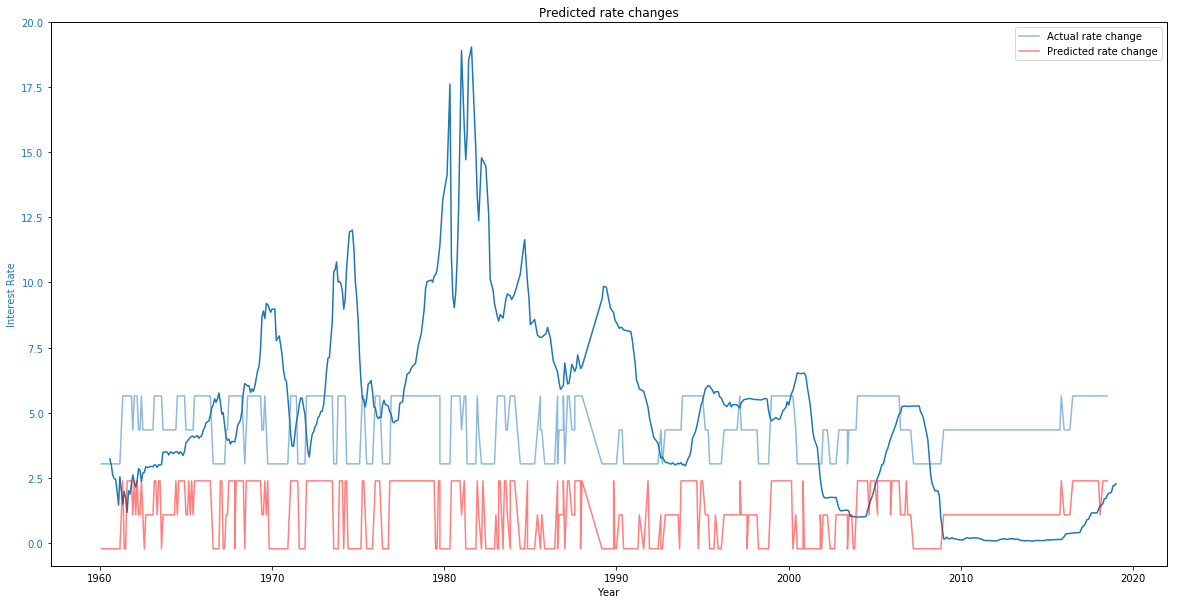

In [242]:
## Plot the interest rate, actual change, predicted change

fig, ax1 = plt.subplots(figsize=(20, 10))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Interest Rate', color=color)
ax1.plot(df_temp[6:].index, df_temp['rate'][6:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
ax2.set_ylim(bottom=-4, top=12)
ax2.get_yaxis().set_visible(False)

color = 'tab:blue'
ax2.set_ylabel('Interest Rate Change', color=color) 
ax2.plot(y_pred['change_6'], color=color, alpha=0.5, label
         ='Actual rate change')
ax2.tick_params(axis='y', labelcolor=color)

color = 'red'
ax2.plot(y_pred['change_6_pred'], color=color, alpha=0.5, label='Predicted rate change')
ax2.tick_params(axis='y', labelcolor=color)

plt.legend()
plt.title('Predicted rate changes')
plt.show()

### 07: Final Model Tuning and Partial Data Testing
Currently the model is sitting at about 65% accuracy on the test data, when trained on a random 75% train sample and predicting a remaining 25% random test split.  Accuracy scores on the training data is not relevant, since the XGBoost model is overfitting the data highly accurately to the training set.<br>
<br>
Currently each observation is considered to be independent of all other observations, no time series data is considered.  Interest rate flow is inherently time series data, each new observation will have some degree of influence on future ones.  For the final model tuning, we'll add a time series component to the model by performing a train/test split based on a time point, then adding a moving average component to smooth out the results.  We'll review results with and without the moving average.<br>
<br>
The model may currently be fitting to non-ideal data such as proper names or document names.  The Beige Book is a relatively new PDF document title that's been running for serveral years, the model may for example be looking for "Beige Book" text strings to predict a flat interest rate.  By removing long periods of recent data, we'll see how this affects the prediction accuracy of recent periods.

1. Re-import data
2. Model creation, testing
3. Plotting results

In [243]:
text = text_tfidf.copy()

In [245]:
## XGBoost model fitting and testing

def xgb_function(text_partial_train, y_partial_train, text_partial_test, y_partial_test):
    xgb_model = XGBClassifier(objective='multi:softmax',
                              max_depth=3,
                              num_classes=3)
    
    # Show performance scores for the partial set
    train_scores = []
    test_scores = []
    for x in range(1,4):
        X_train, X_test, y_train, y_test = train_test_split(text_partial, y_partial)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)

        test_score = round(xgb_model.score(X_test, y_test),2)
        train_score = round(xgb_model.score(X_train, y_train),2)
        print(f'Run {x}... train: {train_score}, test: {test_score}')
        train_scores.append(train_score)
        test_scores.append(test_score)
    print(f'Train partial set average (pre-split): {np.mean(train_scores)}')
    print(f'Test partial set average (pre-split): {np.mean(test_scores)}')
    
    # Show performance scores for the full set
    full_score = round(xgb_model.score(text_partial_test, y_partial_test),2)
    print(f'Post-split date range score: {full_score}')
    
    # Plot predictions
    y_pred = y_partial_test.copy()
    y_pred['change_6_pred'] = xgb_model.predict(text_partial_test)
    y_pred['change_6_pred'] = y_pred['change_6_pred']-2.5
    y_pred['change_6'] = y_pred['change_6']
    
    fig, ax1 = plt.subplots(figsize=(20, 10))

    color = 'tab:blue'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Interest Rate', color=color)
    ax1.plot(df_temp[6:].index, df_temp['rate'][6:], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  
    ax2.set_ylim(bottom=-4, top=12)
    ax2.get_yaxis().set_visible(False)

    color = 'tab:blue'
    ax2.set_ylabel('Interest Rate Change', color=color)  
    ax2.plot(y_pred['change_6'], color=color, alpha=0.5, label='Actual rate change')
    ax2.tick_params(axis='y', labelcolor=color)

    color = 'red'
    ax2.plot(y_pred['change_6_pred'], color=color, alpha=0.5, label='Predicted rate change')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.legend()
    plt.title('Predicted rate changes - Partial Dataset Training')
    plt.show()
    
    return None

In [283]:
## Split data based on date
y_partial_train = y.loc[:'2008-01-01']
text_partial_train = text.loc[:y_partial.shape[0]-1]
y_partial_test = y.loc['2008-02-01':]
text_partial_test = text.loc[:y_partial_test.shape[0]-1]

537

Run 1... train: 1.0, test: 0.61
Run 2... train: 1.0, test: 0.6
Run 3... train: 0.99, test: 0.62
Train partial set average (pre-split): 0.9966666666666667
Test partial set average (pre-split): 0.61
Post-split date range score: 0.5


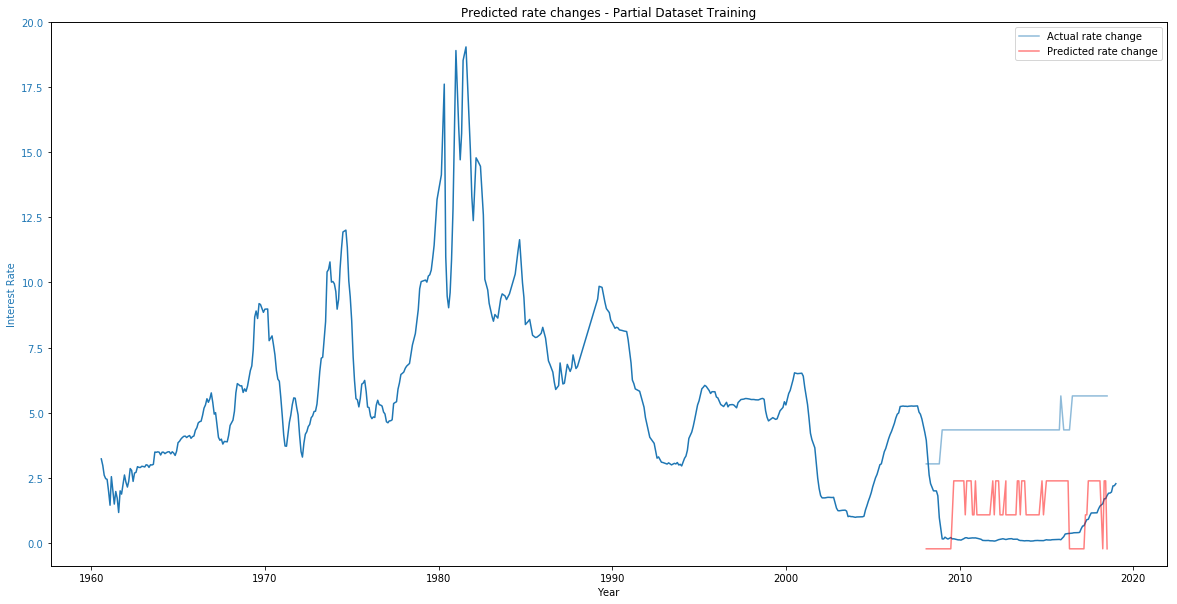

In [286]:
# xgb_function(text_partial, y_partial, text, y)
xgb_function(text_partial_train, y_partial_train, text_partial_test, y_partial_test)

#### 08: Review of Results and Moving Average Addition
In the above example, the model was only trained on data before 2008.  An additional test of the model accuracy was performed after 2008, which resulted in a poor score (around 50%).  In the instance above, it wasn't able to correctly identify the past unprecedented low and neutral interest rate environment of the past 10 years.  For the most-part, it wasn't sure if rates would be flat or increase.  When rates did start to increase, it wasn't sure if it would increase or decrease.<br><br>

Next we'll review how the predictions change when adding a time series component to the model.  Currently, all observations and predictions are considered completely independent of the observations around it.  We'll smooth out the predictions with a single period rounded moving average to reduce the prediction volitility.  <br>

1. Create y-target with moving average
2. Plot predictions
3. Review accuracy score

In [288]:
y_pred = y_partial_test.copy()
y_pred['change_6_pred'] = xgb_model.predict(text_partial_test)
y_pred['change_6'] = y_pred['change_6']
y_pred['change_6_pred_r'] = y_pred['change_6_pred'].rolling(2, min_periods=1).mean().round(0)
y_pred.head(10)

,change_6,change_6_pred,change_6_pred_r
date,,,
2008-02-01,-1.0,-1.0,-1.0
2008-04-01,-1.0,-1.0,-1.0
2008-05-01,-1.0,-1.0,-1.0
2008-07-01,-1.0,-1.0,-1.0
2008-09-01,-1.0,-1.0,-1.0
2008-09-01,-1.0,-1.0,-1.0
2008-10-01,-1.0,-1.0,-1.0
2008-11-01,-1.0,-1.0,-1.0
2009-01-01,0.0,-1.0,-1.0


In [289]:
# Stagger predicted line so it's not overlapping the actual change line
y_pred['change_6_pred_r_s'] = y_pred['change_6_pred_r'] - 2.5

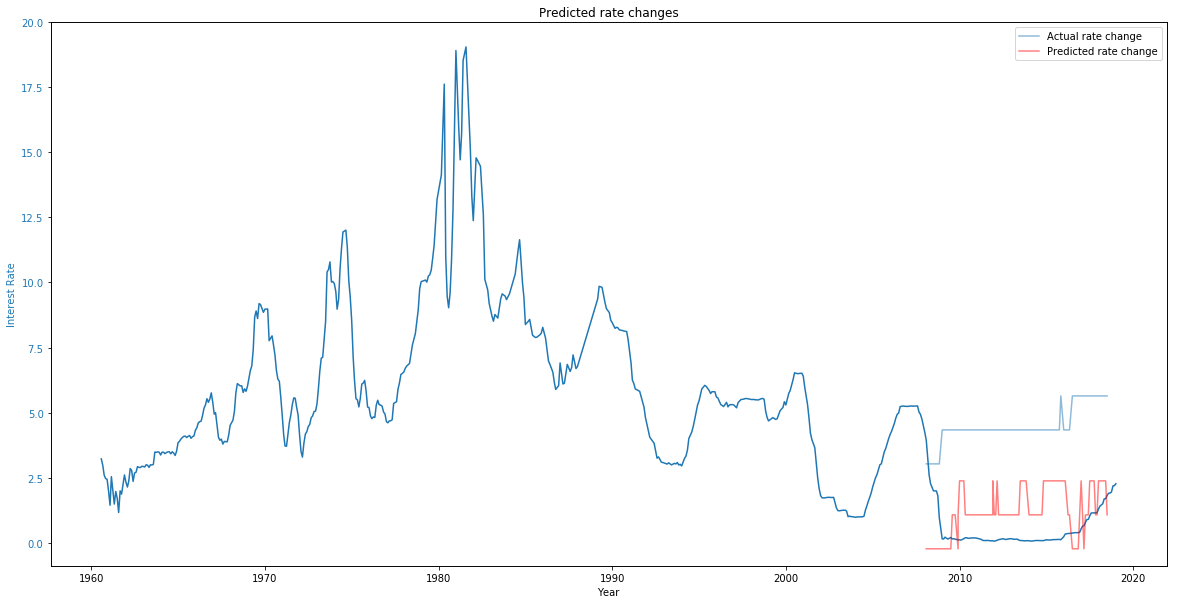

In [290]:
## Plot the interest rate, actual change, predicted change

fig, ax1 = plt.subplots(figsize=(20, 10))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Interest Rate', color=color)
ax1.plot(df_temp[6:].index, df_temp['rate'][6:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
ax2.set_ylim(bottom=-4, top=12)
ax2.get_yaxis().set_visible(False)

color = 'tab:blue'
ax2.set_ylabel('Interest Rate Change', color=color)  
ax2.plot(y_pred['change_6'], color=color, alpha=0.5, label='Actual rate change')
ax2.tick_params(axis='y', labelcolor=color)

color = 'red'
ax2.plot(y_pred['change_6_pred_r_s'], color=color, alpha=0.5, label='Predicted rate change')
ax2.tick_params(axis='y', labelcolor=color)

plt.legend()
plt.title('Predicted rate changes')
plt.show()

In [291]:
## Manual calculation of score
# Sum predictions
y_count = y_pred.shape[0]

# Sum correct predictions
y_pred_correct = y_pred[y_pred['change_6']==y_pred['change_6_pred_r']].shape[0]

# Percentage that was correct
accuracy = y_pred_correct / y_count
print(accuracy)

0.6138613861386139


#### 09: Decreasing the Training Sample
With the moving average, we're at around 60% accuracy.  The accuracy of a full train/test split on using all data is approximately 65%, so we've lost some important features that were unique to the last 10 years of communications.  Interest rates in the US have serveral characteristics that make it challenging for this model to accuractely forecast:
1. Interest rate decision makers change over time.  They have unqiue goals, political environments, economic environments.
2. Metrics that the US Federal Reserve uses to make interest rate decisions changes over time.  Inflation, for example, has been measured differently over time to match the government's political objectives.
3. The FOMC communications change over time: formatting, length, information contained, etc all change over time.  
4. Which FOMC communications to use to represent each month changes month to month, based on the largest file size (for this current model).

Using a moving average did assist in model accuracy.  It may be leaning towards curve-fitting, however smoothing out volitile predictions does add a time series component to the predictions.  The model recommednations look for more of a conistent signal before moving to a recommendation.  We'll review at the end of the notebook possible options for real-world use of the model.<br><br>
Next, we'll review splitting the data to provide it with even less information, only training on data up to the year 2000.<br>

1. Create new sample, split at year 2000
2. Score and plot without moving average
3. Score and plot with moving average

Run 1... train: 0.99, test: 0.59
Run 2... train: 1.0, test: 0.59
Run 3... train: 1.0, test: 0.6
Train partial set average (pre-split): 0.9966666666666667
Test partial set average (pre-split): 0.5933333333333333
Post-split date range score: 0.26


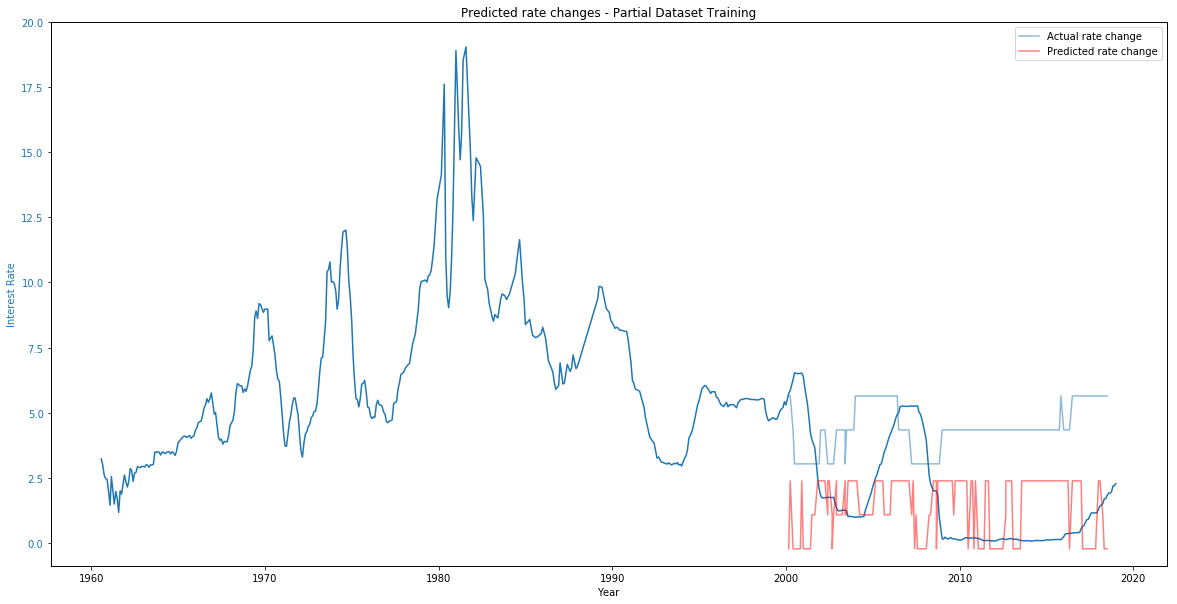

In [293]:
## Split data based on date
y_partial_train = y.loc[:'2000-01-01']
text_partial_train = text.loc[:y_partial.shape[0]-1]
y_partial_test = y.loc['2000-02-01':]
text_partial_test = text.loc[:y_partial_test.shape[0]-1]

## Run model testing, no moving average smoothing
xgb_function(text_partial_train, y_partial_train, text_partial_test, y_partial_test)

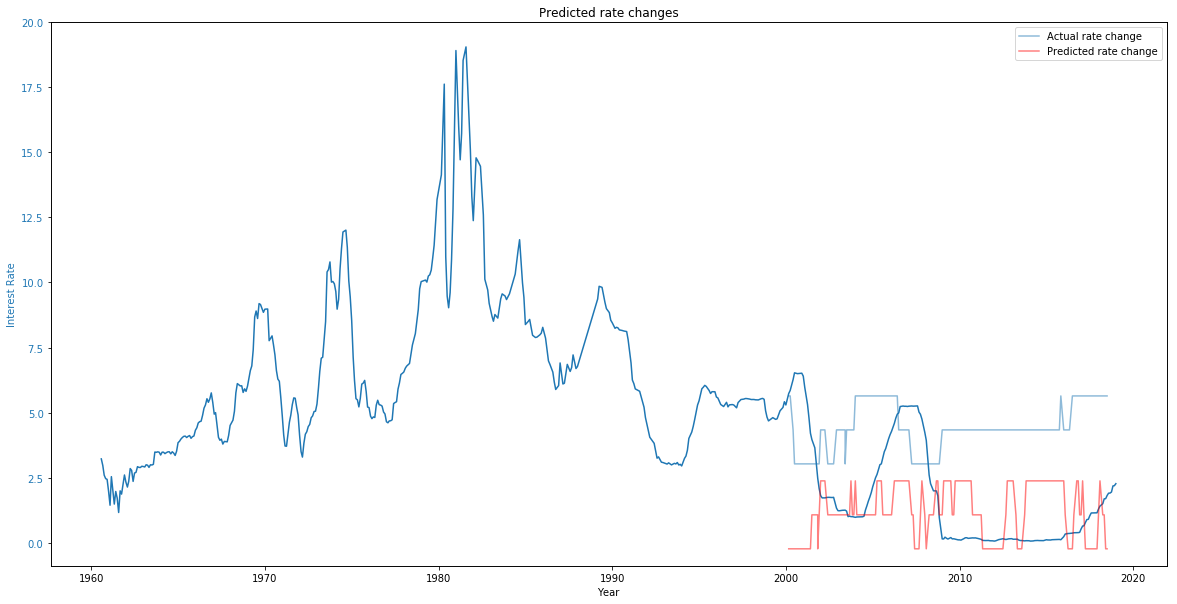

In [294]:
## Moving average smoothing on the predictions
y_pred = y_partial_test.copy()
y_pred['change_6_pred'] = xgb_model.predict(text_partial_test)
y_pred['change_6'] = y_pred['change_6']
y_pred['change_6_pred_r'] = y_pred['change_6_pred'].rolling(2, min_periods=1).mean().round(0)
y_pred.head(10)

# Stagger predicted line so it's not overlapping the actual change line
y_pred['change_6_pred_r_s'] = y_pred['change_6_pred_r'] - 2.5

## Plot the interest rate, actual change, predicted change
fig, ax1 = plt.subplots(figsize=(20, 10))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Interest Rate', color=color)
ax1.plot(df_temp[6:].index, df_temp['rate'][6:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
ax2.set_ylim(bottom=-4, top=12)
ax2.get_yaxis().set_visible(False)

color = 'tab:blue'
ax2.set_ylabel('Interest Rate Change', color=color)  
ax2.plot(y_pred['change_6'], color=color, alpha=0.5, label='Actual rate change')
ax2.tick_params(axis='y', labelcolor=color)

color = 'red'
ax2.plot(y_pred['change_6_pred_r_s'], color=color, alpha=0.5, label='Predicted rate change')
ax2.tick_params(axis='y', labelcolor=color)

plt.legend()
plt.title('Predicted rate changes')
plt.show()

In [295]:
## Manual calculation of score
# Sum predictions
y_count = y_pred.shape[0]

# Sum correct predictions
y_pred_correct = y_pred[y_pred['change_6']==y_pred['change_6_pred_r']].shape[0]

# Percentage that was correct
accuracy = y_pred_correct / y_count
print(accuracy)

0.2887700534759358


## 10: Testing Actual Use-case

In reality, the tool would be used to estimate a rollowing prediction every month.  Accuracy of long-term projections wouldn't be used and wouldn't be practical.  One would also want to train the model on as much relevant data as possible.  As such, the best accuracy score would be scoring it only on how well it predicts the immediate future over time.<br><br>
The final test will be testing a sample of predictions from a large range of time.

In [343]:
# ## Create 5-period change dataframe for comparing model scores

# y_5 = df_temp['rate'].diff(5).shift(-5)
# y_5 = pd.DataFrame(y_5)
# # Drop the NAN columns
# y_5 = y_5[:-5]

# # Create y-target, with threshold for minimum change
# y_5.mask(y_5 > y_threshold, 1, inplace=True)
# y_5.mask(y_5 < -y_threshold, -1, inplace=True)
# y_5.mask((y_5 > -y_threshold) & (y_5 < 0.25), 0, inplace=True)
# y_5.head()

,rate
date,
1960-02-01,-1.0
1960-03-01,-1.0
1960-04-01,-1.0
1960-05-01,-1.0
1960-06-01,-1.0


In [396]:
y.head()

,change_6
date,
1960-02-01,-1.0
1960-03-01,-1.0
1960-04-01,-1.0
1960-05-01,-1.0
1960-06-01,-1.0


In [439]:
years = []
test_results = []
for x in range(1980,2018):
    years.append(x)

for x in years:
    y_partial = y.loc[:str(x-1)+'-06-30']
    text_partial = text.loc[:y_partial.shape[0]-1]
    
    # Train test split - don't train the model on all data, reduce overfit
    X_train, X_test, y_train, y_test = train_test_split(text_partial, y_partial)
    
    # Train model
    xgb_model.fit(X_train, y_train)
    
    # Make prediction for next period
    pred = xgb_model.predict(text.loc[y_partial.shape[0]-1:y_partial.shape[0]-1])
    actual = y_5[:y_partial.shape[0]-1].tail(1).iloc[0,0]
    if pred == actual:
        test_results.append(1)
    else:
        test_results.append(0)

In [456]:
correct = sum(num == 1 for num in test_results)
incorrect = sum(num == 0 for num in test_results)
score = (correct / (correct+incorrect))
print('Score from a sample range: ' + str(round(score,2)))

Score from a sample range: 0.66


### 10: Final Model Review and Conclusion
In the above example, we'll review both the train/test split scores on the months before the year 2000, and the test score on the months after 2000.<br>
The test score before the year 2000 were lower than the test scores when using the full dataset for the train/test split.  This may be due to the model accurately predicting the past 10 year's low interest rate environment.  Before that period, interest rates were much more varied, with frequent directional changes.<br>
The test score after the year 2000, where was provided with no data to train on, performed very poorly with only about 30% accuracy.  It misinterpreted the documents significantly, even with moving average smoothing.<br><br>

Interest rate smoothing was a possible option for increasing accuracy, but provided not to be a substitute for giving more features.
##### How could this model be used?  
Carefully, and only in addition to other tools.<br>
As mentioned, the nature of interest rate environments shifts over time significantly.  The communications, environment, and actions have little connection between 1970 and 2010.  US interest rates are a major subject of endless debate among the most experienced and skilled financial managers.  The intended goals of the FOMC may even not be met, as they react to economic or political shifts.<br><br>
The model would have practical uses, only in addition to using other tools.  The model would also need to be trained on the full dataset, rather than performing a split during a certain year.  The model's performance in changing environments requires some features built on the current environment.  To note, it has a moderately high likelihood of missing changing signals in untrained and unknown environments.  The model may be trained currently to view the current environment as 'always flat, only increasing if it sees X signals'.  It may not know when an interest rate turn may happen, if one of two factors is true:
1. The model is not trained on anticipating a possible down-turn.  The language the Powell FOMC may use may be unique and not share past FOMC communication characteristics before a down-turn.
2. The down-turn may be unique compared to past incidents, economically, and the FOMC communications may not include any features that anticipate a recession or monetary easing.

If the model is not trained on a specific environment's communications, the communications may hold features that are significantly different from the past, and a model not trained on the new environment may have no predictive value.  A model trained on the new current environment may be overfitting to the environment __so far__, and have no ability to anticipate a change.<br><br>
There is no easy solution to forecasting US interest rates.  NLP on FOMC communications may be a valuable tool if combined with several other tools.  It should only be considered one flag.  Even if a current market environment is unique, FOMC communications may still contain feature similarities from other past market shocks that forecasted rate change (Fed over-confidence, fed warnings about risk, etc).<br>
<br>
This current bull run (as of February 2019) has been unprecedented, the portion of money managed solely on quant models is one of those never before experienced features.  The weaknesses identified with this project are a common weakness of any quantitative machine learning model that's been given responsibility over financial actions.  They won't consider those [black swans](https://en.wikipedia.org/wiki/The_Black_Swan_(Taleb_book)), and they only what they've seen before.  Training a model on data going back 50 years might give the illusion of a robust model, but it's easy to pull out a small part of its knowledge and realize just how weak it is.  <br><br>
__Every bear until now has jumped out of a bush, the next one might jump down from a tree.__  It's a great supplement to have a model beside you keeping an eye on those bushes, as long as it still has a human looking out for everything else.